In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from ast import literal_eval
from collections import Counter
from scipy.stats import kruskal

### Load data

In [925]:
data = pd.read_csv("../outputs/full_dataset_without_openl3.csv")
data['strategy'] = data['strategy'].apply(
    lambda s: literal_eval(s) if isinstance(s, str) and s.strip().startswith('[') else s
)

X_raw = data.drop(columns='strategy')
X = X_raw.iloc[:, 5:]

y = data['strategy']

In [801]:
X_raw[]

,url,response_id,name,artists,meta.artist_y,meta.duration,meta.year,popularity,lowlevel.dissonance.mean,lowlevel.dissonance.stdev,...,lowlevel.mfcc.mean.3,lowlevel.mfcc.mean.4,lowlevel.mfcc.mean.5,lowlevel.mfcc.mean.6,lowlevel.mfcc.mean.7,lowlevel.mfcc.mean.8,lowlevel.mfcc.mean.9,lowlevel.mfcc.mean.10,lowlevel.mfcc.mean.11,lowlevel.mfcc.mean.12
0,https://open.spotify.com/track/4Lbktkg0Ib1bFDu...,R_2oS0VRFGHi3daXX,I'd Rather Die,['Deli Girls'],Deli Girls,192,2019,23,0.462420,0.043769,...,25.680008,-12.469234,8.216922,0.596550,3.414942,-1.069987,-2.859599,-5.005867,-2.799207,-4.533410
1,https://open.spotify.com/track/3xXBsjrbG1xQIm1...,R_2VdoBUAa69ab0h6,One More Light,['Linkin Park'],Linkin Park,255,2017,77,0.382925,0.071163,...,16.575073,-8.169375,-15.547631,-8.102405,0.221022,4.149209,-8.138163,-8.708669,-0.803029,-6.525937
2,https://open.spotify.com/track/2okho7vU7Nsq1UZ...,R_8TFOXwMwo2RtzTg,Fearless,['Taylor Swift'],Taylor Swift,242,2008,52,0.458120,0.033618,...,18.044010,4.431456,-0.113655,6.105258,-0.729119,2.463936,0.571365,-5.139260,-0.345709,-2.948164
3,https://open.spotify.com/track/58i5wpN3tZUjHv5...,R_2HOcWQ0Ao3rvWQl,You Spent All Your Love - Anniversary Edition,['Mega Mango'],Mega Mango,257,2023,24,0.452582,0.046017,...,33.423115,-1.343754,-4.756132,1.543039,-0.194261,-0.844378,6.786612,-0.601793,3.153393,-2.596997
4,https://open.spotify.com/track/5Ng6UbryNd3eds2...,R_8ZTYiKxXbBb081e,Spellbound,['Siouxsie and the Banshees'],Siouxsie and the Banshees,197,1981,64,0.467697,0.026549,...,18.966791,21.274265,13.211453,3.229613,1.986478,0.994890,3.535614,-1.532835,-1.820151,-3.961347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,https://open.spotify.com/track/174yp4XX5F3HGX8...,R_8wt2bq6XlrxNtUi,Know That You Are Loved,['Cleo Sol'],Cleo Sol,202,2021,57,0.375781,0.068152,...,-4.406195,-0.980211,-6.064624,9.665769,-7.220973,2.043963,-6.154091,2.262631,-2.980292,-3.829046
1027,https://open.spotify.com/track/59c2xv2kMzYM6HR...,R_8wt2bq6XlrxNtUi,Sweet Boy,['Malcolm Todd'],Malcolm Todd,180,2024,80,0.438227,0.043579,...,0.998161,-7.379012,-12.412846,-10.695750,-3.160185,-6.000624,-6.252857,-3.719038,-2.050446,-4.362484
1028,https://open.spotify.com/track/7Cu2COdH93Mnuir...,R_8wt2bq6XlrxNtUi,Streetcar,['Daniel Caesar'],Daniel Caesar,246,2015,7,0.436262,0.057137,...,3.617328,-10.709569,-8.966742,-16.132315,-1.363405,-11.015938,-4.943199,-6.311774,-7.569437,-9.552664
1029,https://open.spotify.com/track/5kWy7PYqTxAydB0...,R_8wt2bq6XlrxNtUi,Invitations (Disco Mix),['Shakatak'],Shakatak,257,2017,28,0.467159,0.024216,...,25.434406,3.628206,-2.514938,-0.874196,-2.448579,-4.528911,-1.705542,-5.572200,-1.876427,-4.787106


In [879]:
df_survey = pd.read_csv("../outputs/filtered_survey_data.csv")
df_survey_full = pd.read_csv("../data/final_survey_data.csv").iloc[2:]
df_meta = pd.read_json("../data/metadata_full.json")

### Count # of songs per strategy

In [227]:
def count_songs_per_strategy(strategy_col):
    c = Counter()

    for x in strategy_col:
        if isinstance(x, str):
            c[x] += 1
        elif isinstance(x, list):
            for item, count in x:
                c[item] += count
    
    return c.most_common()

song_count_per_strategy = count_songs_per_strategy(y)

total = sum(count for _, count in song_count_per_strategy)

for (strategy, count) in song_count_per_strategy:
    pct = (count / total) * 100
    print(f"{strategy}: {count} ({pct:.2f}%)")

entertainment: 218 (20.11%)
strong_sensation: 163 (15.04%)
diversion: 163 (15.04%)
discharge: 157 (14.48%)
revival: 150 (13.84%)
mental_work: 128 (11.81%)
solace: 105 (9.69%)


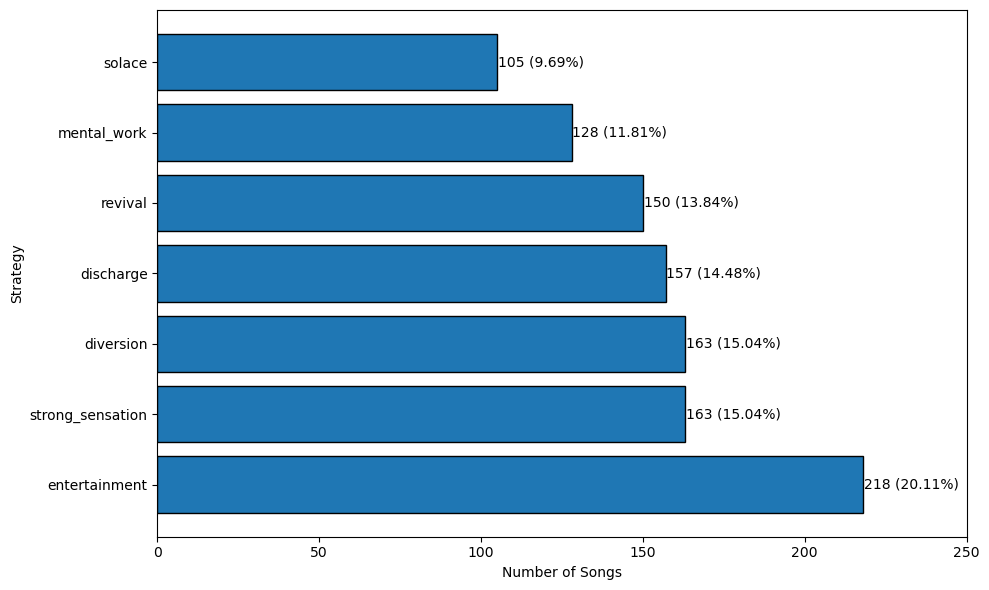

In [262]:
strategies = [s for s, _ in song_count_per_strategy]
counts = [c for _, c in song_count_per_strategy]

total = sum(counts)
percentages = [(c / total) * 100 for c in counts]

plt.figure(figsize=(10, 6))
plt.barh(strategies, counts, edgecolor='black')

for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(count + 0.2, i, f"{count} ({pct:.2f}%)", va='center')
    
plt.xlabel("Number of Songs")
plt.xlim(0, 250)
plt.ylabel("Strategy")
plt.tight_layout()
plt.savefig("../outputs/figs/number_songs_per_strategy.png")
plt.show()

### Plot stress frequency and intensity

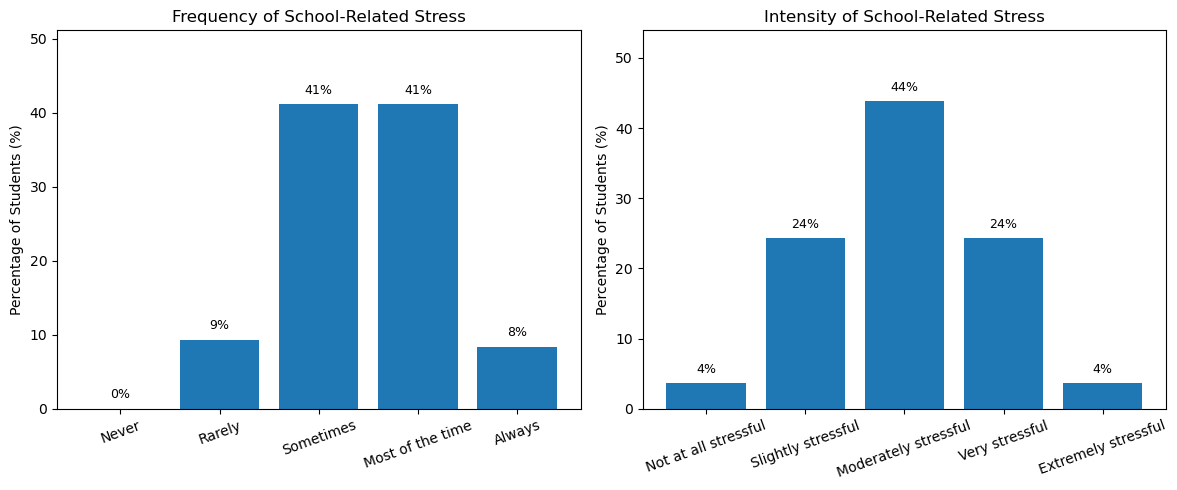

In [977]:
q18_labels = ["Never", "Rarely", "Sometimes", "Most of the time", "Always"]
q18_values = [0, 10, 44, 44, 9]

q19_labels = ['Not at all stressful', 'Slightly stressful', 'Moderately stressful', 'Very stressful', 'Extremely stressful']
q19_values = [4, 26, 47, 26, 4]

q18_percent = [v / 107 * 100 for v in q18_values]
q19_percent = [v / 107 * 100 for v in q19_values]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q18
bars1 = axes[0].bar(q18_labels, q18_percent)
axes[0].set_title("Frequency of School-Related Stress", fontsize=12)
axes[0].set_ylabel("Percentage of Students (%)", fontsize=10)
axes[0].set_ylim(0, max(q18_percent) + 10)
axes[0].tick_params(axis='x', rotation=20)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 1,
                 f"{height:.0f}%", ha='center', va='bottom', fontsize=9)

# Q19
bars2 = axes[1].bar(q19_labels, q19_percent)
axes[1].set_title("Intensity of School-Related Stress", fontsize=12)
axes[1].set_ylabel("Percentage of Students (%)")
axes[1].set_ylim(0, max(q19_percent) + 10)
axes[1].tick_params(axis='x', rotation=20)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 1,
                 f"{height:.0f}%", ha='center', va='bottom', fontsize=9)
plt.show()


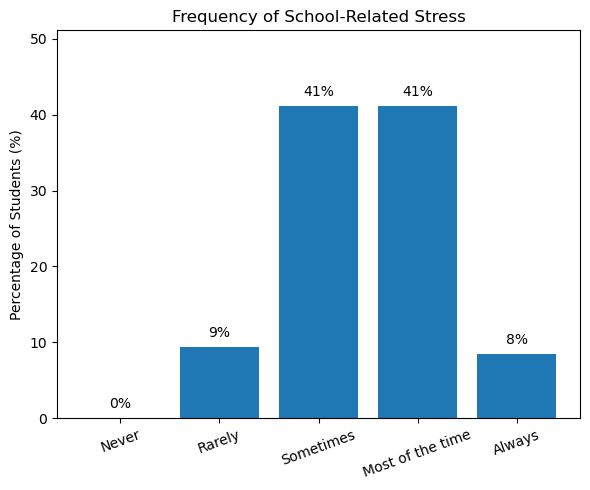

In [983]:
# Q18 
plt.figure(figsize=(6, 5))
bars1 = plt.bar(q18_labels, q18_percent)
plt.title("Frequency of School-Related Stress", fontsize=12)
plt.ylabel("Percentage of Students (%)", fontsize=10)
plt.ylim(0, max(q18_percent) + 10)
plt.xticks(rotation=20, fontsize=10)

for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.0f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/figs/frequency_stress.png")
plt.show()

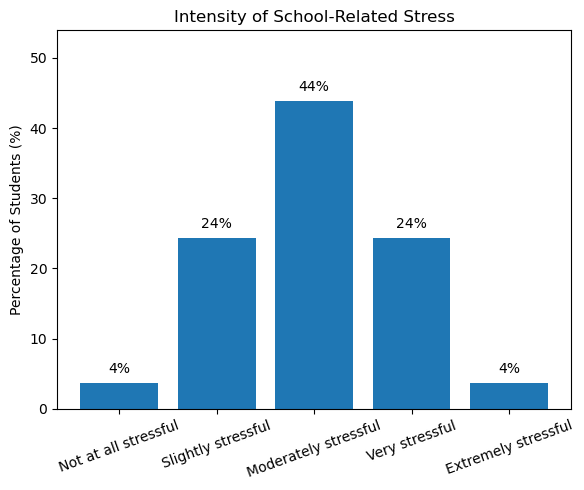

In [985]:
# --- Plot Q19 ---
plt.figure(figsize=(6, 5))
bars2 = plt.bar(q19_labels, q19_percent)
plt.title("Intensity of School-Related Stress", fontsize=12)
plt.ylabel("Percentage of Students (%)", fontsize=10)
plt.ylim(0, max(q19_percent) + 10)
plt.xticks(rotation=20, fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f"{height:.0f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("../outputs/figs/intensity_stress.png")
plt.show()

### Plot frequency of coping habits

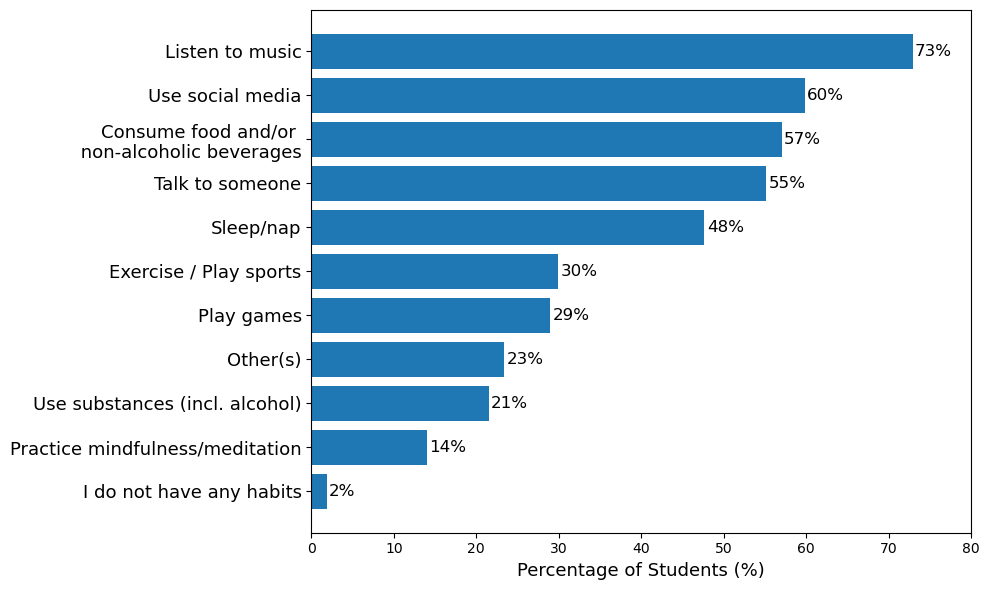

In [1018]:
responses = [
    "Listen to music",
    "Consume food and/or \n non-alcoholic beverages",
    "Use social media",
    "Talk to someone",
    "Sleep/nap",
    "Exercise / Play sports",
    "Play games",
    "Use substances (incl. alcohol)",
    "Other(s)",
    "Practice mindfulness/meditation",
    "I do not have any habits"
]

counts = [78, 61, 64, 59, 51, 32, 31, 23, 25, 15, 2]
total = sum(counts)
df_q20 = pd.DataFrame({"Response": responses, "Count": counts})
df_q20["Percent"] = df_q20["Count"] / 107 * 100
df_q20 = df_q20.sort_values("Count", ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.barh(df_q20["Response"], df_q20["Percent"])
plt.gca().invert_yaxis()

# plt.title("Typical Stress-Coping Habits", fontsize=13)
plt.xlabel("Percentage of Students (%)", fontsize=13)
plt.xlim(0,80)
plt.yticks(fontsize=13)

for bar, count, pct in zip(bars, df_q20["Count"], df_q20["Percent"]):
    plt.text(pct + 0.3, bar.get_y() + bar.get_height()/2,
             f"{pct:.0f}%", va='center', fontsize=12)

plt.savefig("../outputs/figs/coping_habits.png", bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()


### Count # of participants who utilise each strategy

In [229]:
strategy_bool_qnum = {
    "entertainment": "Q48",
    "revival": "Q49",
    "strong_sensation": "Q50",
    "diversion": "Q51",
    "discharge": "Q52",
    "mental_work": "Q53",
    "solace": "Q54",
}

df_strategy_bool = df_survey[strategy_bool_qnum.values()]
df_strategy_bool.columns = strategy_bool_qnum.keys()    

# Convert string to booleans
for col in df_strategy_bool:
    df_strategy_bool[col] = df_strategy_bool[col].replace({"Yes": True, "No": False})

/var/folders/qc/8fy08h5s33n4rrmz09_8bv680000gn/T/ipykernel_84701/3793540016.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_strategy_bool[col] = df_strategy_bool[col].replace({"Yes": True, "No": False})


In [238]:
strategy_use_dict = {}

# Count the number of participants that use each strategy
for col in df_strategy_bool:
    count = df_strategy_bool[col].dropna().sum()
    strategy_use_dict[col] = count

# Sort the items by the frequency
strategy_use_dict = {key: value for key, 
               value in sorted(strategy_use_dict.items(), 
                               key=lambda item: item[1])}

print("The number of participants that report utilsing music for the following stress-relief strategies:")
for (strategy, count) in strategy_use_dict.items():
    print("===",strategy,":",count)


The number of participants that report utilsing music for the following stress-relief strategies:
=== solace : 31
=== mental_work : 42
=== revival : 44
=== strong_sensation : 47
=== diversion : 48
=== discharge : 50
=== entertainment : 61


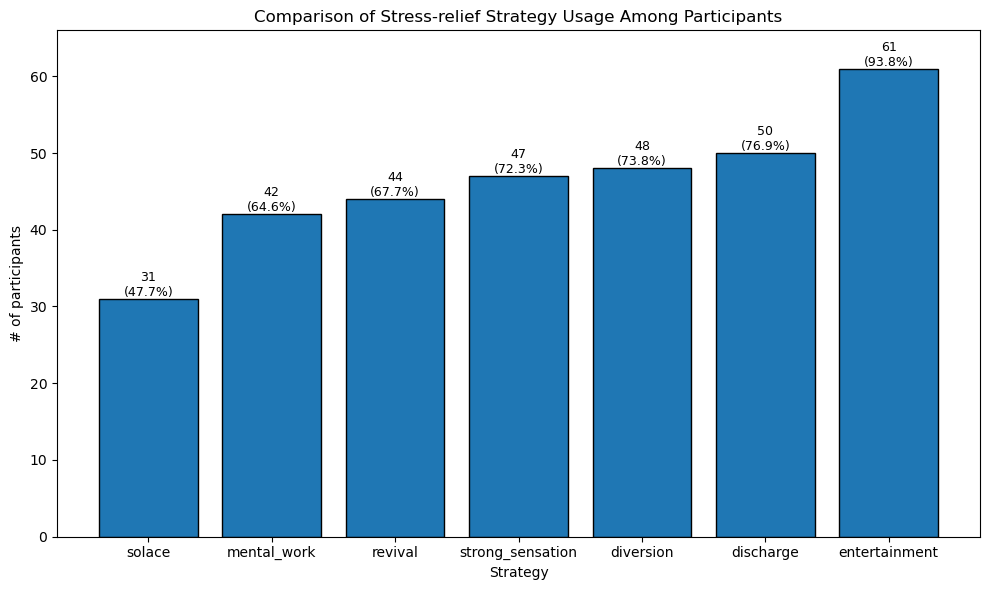

In [297]:
plt.figure(figsize=(10, 6))
bars = plt.bar(
    strategy_use_dict.keys(), strategy_use_dict.values(),
    capsize=5,
    edgecolor='black'
)

for bar in bars:
    height = bar.get_height()
    pct = (height / 65) * 100
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.ylabel("# of participants")
plt.xlabel("Strategy")
plt.ylim(0, max(strategy_use_dict.values()) + 5)
plt.xticks(rotation=0)
plt.title("Comparison of Stress-relief Strategy Usage Among Participants")
plt.tight_layout()
plt.savefig("../outputs/figs/comparison_of_strategy_usage(counts).png")
plt.show()

### Count the average # of submitted songs per strategy by participants

In [154]:
strategy_matrix_question_number = { 
       "entertainment": "20",
        "revival": "41",
        "strong_sensation": "45",
        "diversion": "48",
        "discharge": "51",
        "mental_work": "54",
        "solace": "57"
    }

def extract_song_columns(df, question_number, song_number):
    wanted_cols = [f"Q{question_number}#1_{song_number}_{1}" if f"Q{question_number}#1_{song_number}_1" in df.columns else None]
    return wanted_cols 


In [176]:
# Extract survey columns with answers containing:
#  (1) whether the participant uses the strategy for stress relief
#  (2) recommended song (names)

for (strategy, qnum) in strategy_matrix_question_number.items():
    for i in range(1, 6):
        cols = extract_song_columns(df_survey, qnum, i)

all_cols = list(strategy_bool_qnum.values())

for strategy, qnum in strategy_matrix_question_number.items():
    for i in range(1, 6):
        cols = extract_song_columns(df_survey, qnum, i)
        all_cols.extend(cols)

df_bool_songs = df_survey[all_cols]

In [216]:
# Count the number of songs submitted by participants for a strategy, if it is used by the participant
df_songs = df_bool_songs.iloc[:, 7:]
counts = {}

for strategy, qnum in strategy_bool_qnum.items():
    strategy_song_cols = df_songs.columns[df_songs.columns.str.startswith(f"Q{strategy_matrix_question_number[strategy]}")]
    counts[f"{strategy}_song_count"] = (
        (df_survey[qnum] == "Yes") * df_songs[strategy_song_cols].notna().sum(axis=1)
    )

df_songs_counts = pd.DataFrame(counts)

In [215]:
print("Number of songs submitted per strategy, if the strategy is used by the participant")
print()
for col in df_songs_counts:
    # only consider if participants put at least one song
    strategy_col = df_songs_counts[col].replace(0, np.nan)
    mean = strategy_col.mean()
    std = strategy_col.std()
    print(col)
    print(f"    mean : {mean:.2f}")
    print(f"    std : {std:.2f}")

Number of songs submitted per strrategy, if the strategy is used by the participant

entertainment_song_count
    mean : 3.92
    std : 1.57
revival_song_count
    mean : 3.64
    std : 1.45
strong_sensation_song_count
    mean : 3.66
    std : 1.49
diversion_song_count
    mean : 3.81
    std : 1.47
discharge_song_count
    mean : 3.75
    std : 1.52
mental_work_song_count
    mean : 3.37
    std : 1.62
solace_song_count
    mean : 3.55
    std : 1.57


### Investigate duplicated strategies

In [95]:
duplicates = [i for i in y if isinstance(i, list)]
single_strategy_dupes = [i for i in y if isinstance(i, list) and len(i)==1] # songs that occur more than once, but with the strategy
multi_strategy_dupes = [i for i in y if isinstance(i, list) and len(i)>1] # songs that occur more than once, but with different strategies

print(f"Total number of duplicated songs: {len(duplicates)}")
print(f"Total number of duplicated songs with one strategy: {len(single_strategy_dupes)}")
print(f"Total number of duplicated songs with multiple strategies: {len(multi_strategy_dupes)}")

Total number of duplicated songs: 51
Total number of duplicated songs with one strategy: 15
Total number of duplicated songs with multiple strategies: 36


#### Which strategies are occur together frequently?

In [93]:
counter = Counter(frozenset(x) for x in multi_strategy_dupes)
for k, v in sorted(counter.items(), key=lambda x: x[1], reverse=True):
    print(list(k), v)

[('discharge', 1), ('mental_work', 1)] 6
[('entertainment', 1), ('diversion', 1)] 4
[('discharge', 1), ('revival', 1)] 3
[('revival', 1), ('diversion', 1)] 3
[('discharge', 1), ('strong_sensation', 1)] 3
[('revival', 1), ('entertainment', 1)] 3
[('solace', 1), ('strong_sensation', 1)] 2
[('solace', 1), ('mental_work', 1)] 2
[('mental_work', 1), ('diversion', 1)] 2
[('strong_sensation', 1), ('mental_work', 1)] 2
[('revival', 1), ('strong_sensation', 1)] 1
[('discharge', 1), ('strong_sensation', 1), ('solace', 1)] 1
[('entertainment', 2), ('revival', 1)] 1
[('discharge', 1), ('entertainment', 1)] 1
[('solace', 1), ('entertainment', 1)] 1
[('solace', 1), ('diversion', 1)] 1


### Difficulty ratings per strategy

In [25]:
difficulty_strategy = {
    "entertainment": "Q29",
    "revival": "Q30",
    "strong_sensation": "Q46",
    "diversion": "Q49.1",
    "discharge": "Q52.1",
    "mental_work": "Q55",
    "solace": "Q58"
}

flipped_difficulty_strategy = {v: k for k, v in difficulty_strategy.items()}
difficulty_df = df_survey[difficulty_strategy.values()]

likert_map = {
    "Extremely easy": 1,
    "Somewhat easy": 2,
    "Neither easy nor difficult": 3,
    "Somewhat difficult": 4,
    "Extremely difficult": 5
}

difficulty_numeric = difficulty_df.replace(likert_map)

/var/folders/qc/8fy08h5s33n4rrmz09_8bv680000gn/T/ipykernel_84701/122519548.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  difficulty_numeric = difficulty_df.replace(likert_map)


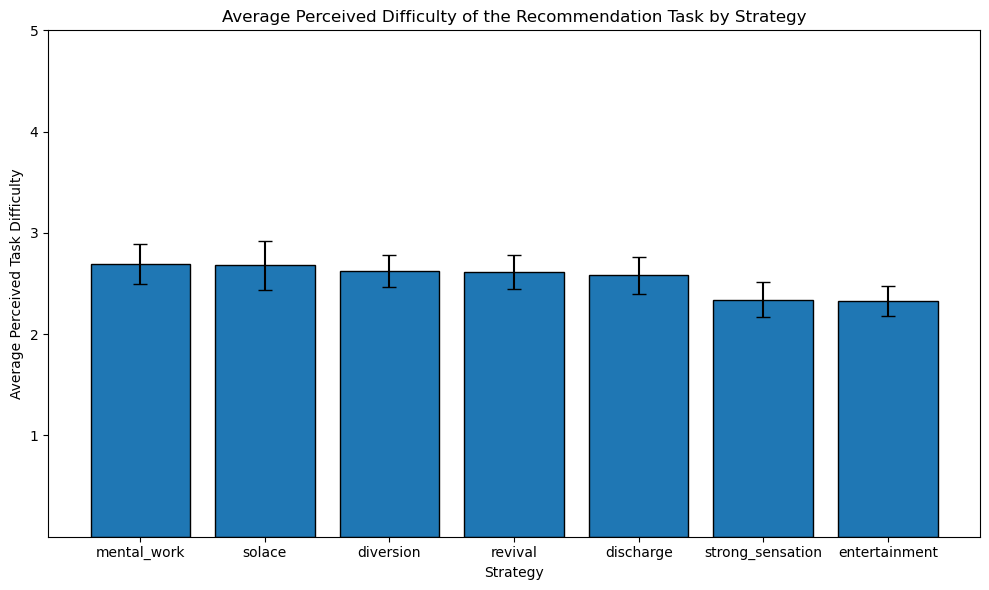

In [284]:
# Compute mean and standard error
mean_difficulty = difficulty_numeric.mean()
sem_difficulty = difficulty_numeric.sem() # standard error of the mean

mean_difficulty = mean_difficulty.sort_values(ascending=False)
sem_difficulty = sem_difficulty[mean_difficulty.index]

strategies = [flipped_difficulty_strategy[col] for col in mean_difficulty.index]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(strategies)))

plt.figure(figsize=(10, 6))
plt.bar(
    strategies,
    mean_difficulty.values,
    yerr=sem_difficulty.values,
    capsize=5,       
    edgecolor='black'
)

plt.ylabel("Average Perceived Task Difficulty")
plt.xlabel("Strategy")
plt.xticks(rotation=0)
plt.yticks(
    [1, 2, 3, 4, 5],
    [1, 2, 3, 4, 5]
)
plt.title("Average Perceived Difficulty of the Recommendation Task by Strategy")
plt.tight_layout()
plt.savefig("../outputs/figs/average_perceived_difficulty_per_strategy.png")
plt.show()


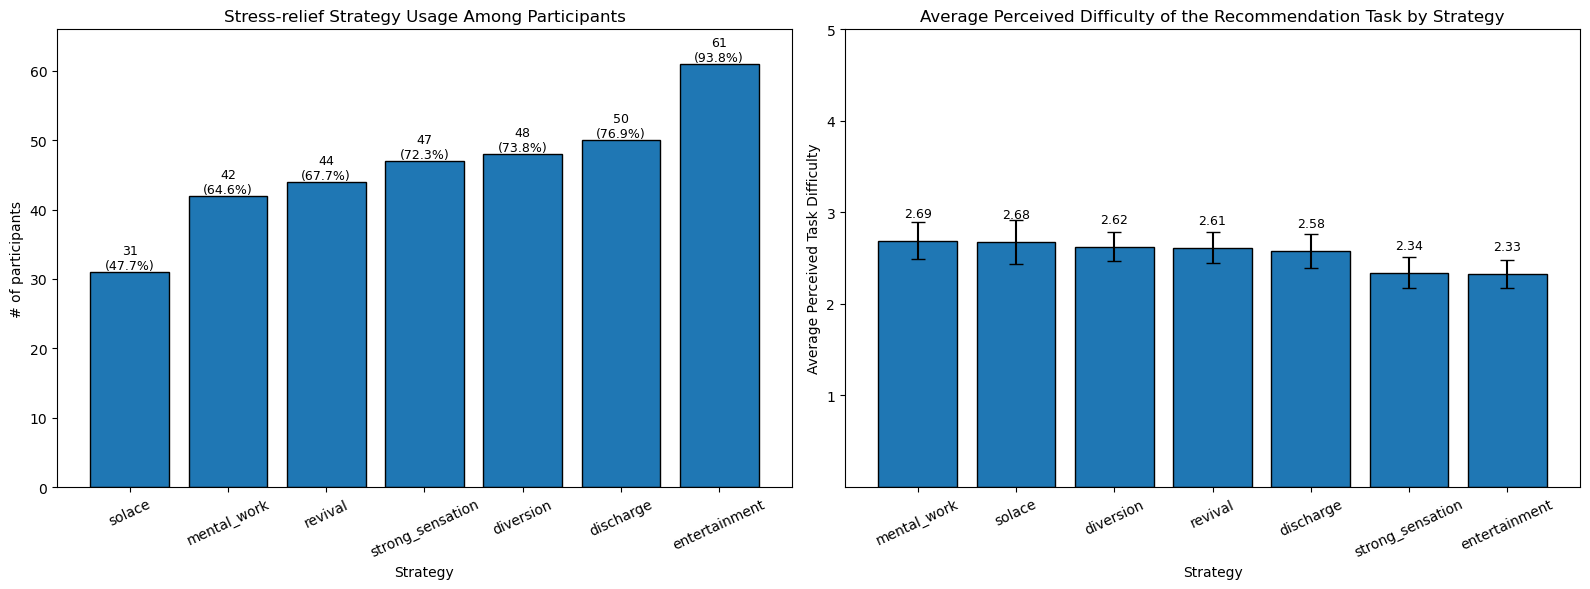

In [298]:
# Plot difficulty scores and the number of participants on the same figure (side-by-side)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# First plot (left): Number of participants per strategy
bars = axes[0].bar(
    strategy_use_dict.keys(), strategy_use_dict.values(),
    capsize=5,
    edgecolor='black'
)

total = sum(strategy_use_dict.values())

for bar in bars:
    height = bar.get_height()
    pct = (height / 65) * 100
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}\n({pct:.1f}%)",
        ha='center',
        va='bottom',
        fontsize=9
    )

axes[0].set_ylabel("# of participants")
axes[0].set_xlabel("Strategy")
axes[0].set_ylim(0, max(strategy_use_dict.values()) + 5)
axes[0].set_xticks(list(strategy_use_dict.keys()))
axes[0].set_xticklabels(strategy_use_dict.keys(), rotation=25)
axes[0].set_title("Stress-relief Strategy Usage Among Participants")


# First plot (right): Average difficulty rating per strategy
bars2 = axes[1].bar(
    strategies,
    mean_difficulty.values,
    yerr=sem_difficulty.values,
    capsize=5,
    edgecolor='black'
)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(
        bar.get_x() + bar.get_width() / 2,
        height+0.23,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9
    )

axes[1].set_ylabel("Average Perceived Task Difficulty")
axes[1].set_xlabel("Strategy")
axes[1].set_xticks(strategies)
axes[1].set_xticklabels(strategies, rotation=25)
axes[1].set_yticks([1, 2, 3, 4, 5])
axes[1].set_title("Average Perceived Difficulty of the Recommendation Task by Strategy")

plt.tight_layout()
plt.savefig("../outputs/figs/strategy_usage_and_average_difficulty.png")
plt.show()

In [223]:
### PART 1: Inventarise the number of valid ratings and NaNs

# Uses difficulty strategy (defined earlier) to get proper name labels
difficulty_named = difficulty_numeric.rename(columns={v: k for k, v in difficulty_strategy.items()})

# Calculated number of valid difficulty ratings per strategy, and number of NaNs
print("Number of valid difficulty ratings per strategy:")
print(difficulty_named.count().sort_values(ascending=False))

print("\nNumber of missing ratings (NaN) per strategy:")
print(difficulty_named.isna().sum().sort_values(ascending=False))

### PART 2: Kruskal-Wallis H test (nonparametric ANOVA)

# Drops all NaNs
groups = [difficulty_named[col].dropna() for col in difficulty_named.columns]

H, p = kruskal(*groups)
print(f"\nKruskal–Wallis test (across strategies):")
print(f"H = {H:.3f}, p = {p:.4f}")

# Post-hoc Dunn tests are only necessary if p < 0.05. If not, we can conclude there is no significnat overall difference.
if p < 0.05:
    df_long = difficulty_named.melt(var_name="strategy", value_name="difficulty").dropna()
    posthoc = sp.posthoc_dunn(df_long, val_col="difficulty", group_col="strategy", p_adjust="holm")
    print("\nPost-hoc Dunn test (Holm-corrected p-values):")
    print(posthoc)
else:
    print("\nNo significant overall difference: no post-hoc Dunn tests needed.")

Number of valid difficulty ratings per strategy:
entertainment       61
discharge           50
diversion           48
strong_sensation    47
revival             44
mental_work         42
solace              31
dtype: int64

Number of missing ratings (NaN) per strategy:
solace              44
mental_work         33
revival             31
strong_sensation    28
diversion           27
discharge           25
entertainment       14
dtype: int64

Kruskal–Wallis test (across strategies):
H = 4.675, p = 0.5861

No significant overall difference: no post-hoc Dunn tests needed.


### Explore importance of lyrics and lyrical/instrumental music

In [448]:
strategy_matrix_question_number = { 
       "entertainment": "20",
        "revival": "41",
        "strong_sensation": "45",
        "diversion": "48",
        "discharge": "51",
        "mental_work": "54",
        "solace": "57"
    }

# Extract columns in the survey that correspond to whether the submitted songs have lyrics
def extract_lyrics_columns(df):
    lyrics_cols = [] 
    for (strategy, qnum) in strategy_matrix_question_number.items():
        wanted_cols = [f"Q{qnum}#3_{i}" for i in [1,2,3,4,5] if f"Q{qnum}#3_{i}" in df.columns]
        lyrics_cols.extend(wanted_cols)
    return lyrics_cols

lyrics_cols = extract_lyrics_columns(df_survey)
df_lyrics = df_survey[lyrics_cols]

# Count the number of instrumental songs for each strategy
lyrics_imp_counts = { 
        "entertainment": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "revival": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "strong_sensation": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "diversion": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "discharge": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "mental_work": {"Lyrics is important": 0, "Lyrics is not important": 0},
        "solace": {"Lyrics is important": 0, "Lyrics is not important": 0}
    }

lyrics_instrumental_counts = { 
        "entertainment": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "revival": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "strong_sensation": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "diversion": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "discharge": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "mental_work": {"Instrumental songs": 0, "Songs with Lyrics": 0},
        "solace": {"Instrumental songs": 0, "Songs with Lyrics": 0},
    }

# Count whether lyrics are important or not 
for strategy, qnum in strategy_matrix_question_number.items():
    strategy_lyrics_cols = df_lyrics.columns[df_lyrics.columns.str.startswith(f"Q{strategy_matrix_question_number[strategy]}")]
    for col in strategy_lyrics_cols:
        lyrics_imp_counts[strategy]["Lyrics is important"] += (df_lyrics[col]=="Yes").sum()
        lyrics_imp_counts[strategy]["Lyrics is not important"] += (df_lyrics[col]=="No").sum()

# Count instrumental vs. non-instrumental 
for strategy, qnum in strategy_bool_qnum.items():
    strategy_lyrics_cols = df_lyrics.columns[df_lyrics.columns.str.startswith(f"Q{strategy_matrix_question_number[strategy]}")]
    for col in strategy_lyrics_cols:
        lyrics_instrumental_counts[strategy]["Instrumental songs"] += (df_lyrics[col]=="There are no lyrics").sum()
        lyrics_instrumental_counts[strategy]["Songs with Lyrics"] += ((df_lyrics[col]=="Yes") | (df_lyrics[col]=="No") ).sum()


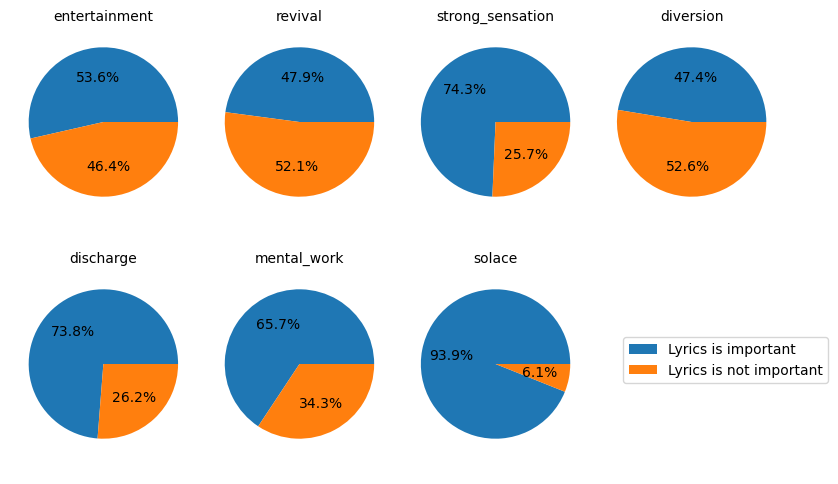

In [991]:
labels = ["Lyrics is important", "Lyrics is not important"]

fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()

for i, (strategy, counts) in enumerate(lyrics_imp_counts.items()):
    values = [counts[l] for l in labels]
    axs[i].pie(values, autopct='%1.1f%%')
    axs[i].set_title(strategy, fontsize=10)

#Hide unused subplots
for j in range(len(lyrics_imp_counts), 8):
    axs[j].axis('off')

fig.legend(labels, loc='center right', bbox_to_anchor = (0.95, 0.3), fontsize=10)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig("../outputs/figs/lyrics_imporance.png",bbox_inches='tight', dpi=300)
plt.show()

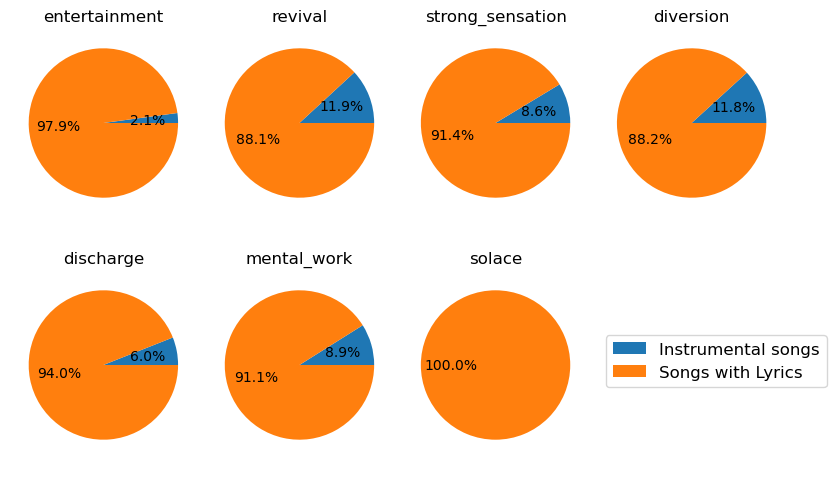

In [990]:
labels = ["Instrumental songs", "Songs with Lyrics"]

fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

for i, (strategy, counts) in enumerate(lyrics_instrumental_counts.items()):
    values = [counts[l] for l in labels]
    axs[i].pie(values, autopct=autopct_format)
    axs[i].set_title(strategy, fontsize=12)

#Hide unused subplots
for j in range(len(lyrics_instrumental_counts), 8):
    axs[j].axis('off')

fig.legend(labels, loc='center right', bbox_to_anchor = (0.95, 0.3), fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig("../outputs/figs/instrumental_lyrics.png",bbox_inches='tight', dpi=300)
plt.show()

In [968]:
998/1084

0.9206642066420664

### Count stress-regulation specific music

In [489]:
strategy_matrix_question_number = { 
       "entertainment": "20",
        "revival": "41",
        "strong_sensation": "45",
        "diversion": "48",
        "discharge": "51",
        "mental_work": "54",
        "solace": "57"
    }

# Extract columns in the survey that correspond to whether the submitted songs are used solely for stress-regulation
def extract_stress_specific_columns(df):
    stress_regulation_cols = [] 
    for (strategy, qnum) in strategy_matrix_question_number.items():
        wanted_cols = [f"Q{qnum}#2_{i}" for i in [1,2,3,4,5] if f"Q{qnum}#2_{i}" in df.columns]
        stress_regulation_cols.extend(wanted_cols)
    return stress_regulation_cols

stress_specific_cols = extract_stress_specific_columns(df_survey)
df_stress = df_survey[stress_specific_cols]
    
# Count the stress-specific songs for each strategy
stress_specific_counts = { 
        "entertainment": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "revival": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "strong_sensation":{"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "diversion": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "discharge": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "mental_work": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
        "solace": {"Listened to in other contexts": 0, "Solely listened to in a stress regulation context": 0, "NaN": 0},
    }

for strategy, qnum in strategy_matrix_question_number.items():
    strategy_stress_cols = df_stress.columns[df_stress.columns.str.startswith(f"Q{strategy_matrix_question_number[strategy]}")]
    for col in strategy_stress_cols:
        stress_specific_counts[strategy]["Listened to in other contexts"] += (df_stress[col]=="Yes").sum()
        stress_specific_counts[strategy]["Solely listened to in a stress regulation context"] += (df_stress[col]=="No").sum()
        stress_specific_counts[strategy]["NaN"] += (df_stress[col]).isna().sum()

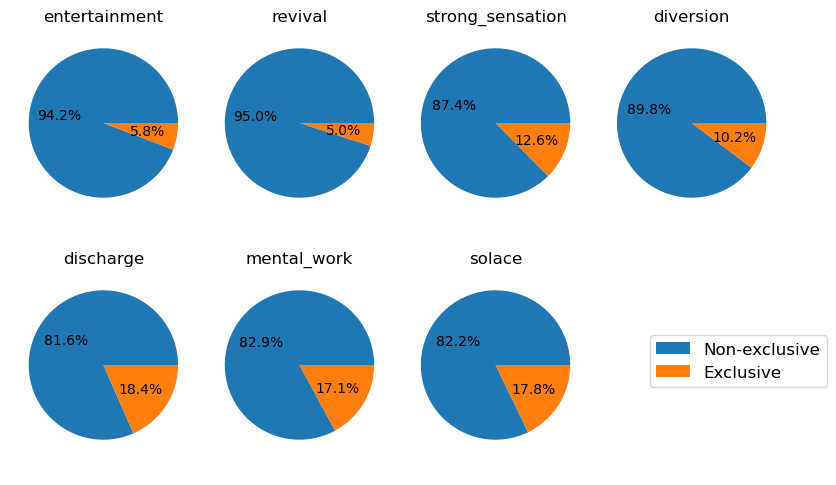

In [996]:

labels = ["Listened to in other contexts", "Solely listened to in a stress regulation context"]
legend_labels = ["Non-exclusive", "Exclusive"]

fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flatten()

def autopct_format(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

for i, (strategy, counts) in enumerate(stress_specific_counts.items()):
    values = [counts[l] for l in labels]
    axs[i].pie(values, autopct=autopct_format, textprops={'fontsize': 10}  )
    axs[i].set_title(strategy, fontsize=12)

#Hide unused subplots
for j in range(len(stress_specific_counts), 8):
    axs[j].axis('off')

fig.legend(legend_labels, loc='center right', bbox_to_anchor = (0.95, 0.3), ncols = 1, fontsize=12)
plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig("../outputs/figs/songs_exclusive_to_stress_regulation.jpeg")
plt.show()

### Genre exploration

In [602]:
### load dataset with genres and strategies present
df_genres = pd.read_csv("../outputs/full_dataset_without_openl3_with_genres.csv")[['strategy', 'genres']]

df_genres['genres'] = df_genres['genres'].apply(
    lambda s: literal_eval(s) if isinstance(s, str) and s.strip().startswith('[') else s
)

### remove tracks that do not have genre information
df_genres = df_genres[df_genres['genres'].map(len) > 0]

In [716]:
df_genres['genres'].map(len).mean()

2.1346153846153846

In [717]:
# Compute the top five genres per strategy
strategy_genre_counts = {}

for strategy in df_genres['strategy'].unique():
    df_st = df_genres[df_genres['strategy']==strategy]
    genre_counts = df_st['genres'].explode().value_counts().head(3)
    strategy_genre_counts[strategy] = genre_counts

for strategy, counts in strategy_genre_counts.items():
    print(f"\nTop 5 genres for {strategy}:")
    for genre, count in counts.items():
        print(f"  {genre}: {count}")


Top 5 genres for strong_sensation:
  rock: 9
  art pop: 8
  classic rock: 7

Top 5 genres for diversion:
  k-pop: 7
  nederpop: 6
  post-punk: 6

Top 5 genres for revival:
  rock: 8
  alternative rock: 6
  classic rock: 5

Top 5 genres for entertainment:
  classic rock: 10
  post-punk: 7
  new wave: 7

Top 5 genres for mental_work:
  art rock: 5
  alternative rock: 4
  shoegaze: 3

Top 5 genres for solace:
  post-punk: 5
  new wave: 4
  soft pop: 4

Top 5 genres for discharge:
  rock: 9
  alternative rock: 6
  garage rock: 6


Additionally split genres into words (e.g. art-pop --> [art, pop]) in order see more coarse-grained differences in genres

In [718]:
import re

# explode genres and tokenize genres into words
df_words = (
    df_genres
      .explode('genres')
      .assign(
          _clean=lambda d: d['genres']
              .astype(str)
              .str.replace(r"[^\w\s\-]", " ", regex=True),
          # split on spaces or dashes
          _tokens=lambda d: d['_clean'].str.split(r"[\s\-]+")
      )
      .explode('_tokens')
      .rename(columns={'_tokens': 'word'})
      .drop(columns=['_clean'])
)

# overall word counts (regardless of strategy)
overall_word_counts = df_words['word'].value_counts()

# word frequency per strategy
word_counts_per_strategy = (
    df_words
      .groupby('strategy')['word']
      .value_counts()
      .rename('count')
      .reset_index()
)

# print top 5 words per strategy
TOP_N = 3
for strategy, sub in word_counts_per_strategy.groupby('strategy'):
    topn = sub.nlargest(TOP_N, 'count', keep='all')
    print(f"\nTop {TOP_N} words for {strategy}:")
    for _, row in topn.iterrows():
        print(f"  {row['word']}: {row['count']}")


Top 3 words for discharge:
  rock: 41
  pop: 24
  metal: 15

Top 3 words for diversion:
  pop: 37
  rock: 19
  hop: 13
  indie: 13

Top 3 words for entertainment:
  rock: 64
  pop: 32
  jazz: 16

Top 3 words for mental_work:
  rock: 29
  pop: 16
  indie: 13

Top 3 words for revival:
  rock: 46
  pop: 30
  hip: 17
  hop: 17

Top 3 words for solace:
  pop: 24
  rock: 20
  punk: 9

Top 3 words for strong_sensation:
  rock: 48
  pop: 30
  metal: 25


What is the distribution of all genres regardless of strategy?

In [616]:
print("Top 10 genres:")
print(df_genres['genres'].explode().value_counts().head(10))

print("\nTop 10 words:")
print(df_words['word'].value_counts().head(10))

Top 10 genres:
genres
rock                35
classic rock        32
alternative rock    31
post-punk           29
art pop             27
new wave            24
k-pop               24
hyperpop            21
art rock            20
nederpop            17
Name: count, dtype: int64

Top 10 words:
word
rock           267
pop            193
indie           73
metal           61
alternative     55
punk            54
jazz            48
hop             47
art             47
hip             40
Name: count, dtype: int64


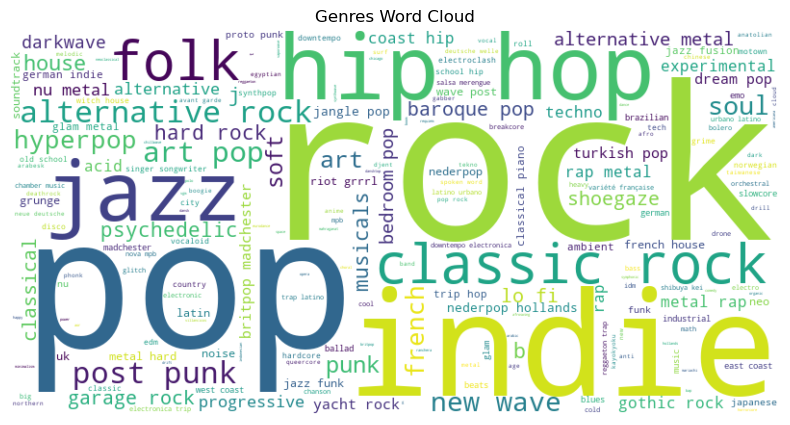

In [600]:
# Make a word cloud of genres within the dataset
from wordcloud import WordCloud

genres_text = " ".join(df_genres['genres'].explode())
wordcloud = WordCloud(width=800, height=400, background_color='white', ).generate(genres_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title("Genres Word Cloud")
plt.show()

### Comparing key-finding algorithms (Krumhansl, Temperley, EDMA, Essentia default)

In [ ]:
df_audio_features = pd.read_csv("../outputs/df_audio_features.csv")
df_keys = df_audio_features.loc[:, df_audio_features.columns[df_audio_features.columns.str.startswith("tonal.key")].tolist() + ["tonal.chords_key", "tonal.chords_scale"]]

In [42]:
alg_cols = {
    "krumhansl": ("tonal.key_krumhansl.key", "tonal.key_krumhansl.scale"),
    "temperley": ("tonal.key_temperley.key", "tonal.key_temperley.scale"),
    "edma": ("tonal.key_edma.key", "tonal.key_edma.scale"),
    "chords":("tonal.chords_key", "tonal.chords_scale"),  
}

# combine the "key" and "scale" for each algorithm
for alg, (kcol, scol) in alg_cols.items():
    if kcol in df_keys.columns and scol in df_keys.columns:
        out_col = f"tonal.key_{alg}.key_scale" if alg != "chords" else "tonal.chords_key_scale"
        df_keys[out_col] = df_keys[kcol].astype(str).fillna("") + "_" + df_keys[scol].astype(str).fillna("")

key_scales = df_keys.loc[:, df_keys.columns.str.endswith("key_scale")]

# get the key with the most "votes" among the four algorithms
key_scales["majority"] = key_scales.apply(lambda row: Counter(row.values).most_common(1)[0][0], axis=1)

# for each algorithm, count the number of disagreements with the "majority vote"
algo_cols = [c for c in key_scales.columns if c.endswith("key_scale") and c != "majority"]
disagree_counts = {}

for col in algo_cols:
    if col == "tonal.chords_key_scale":
        alg = "chords"
    else:
        m = re.search(r"tonal\.key_(.+?)\.key_scale$", col)
        alg = m.group(1)
    disagreements = key_scales[col] != key_scales["majority"]
    disagree_counts[alg] = int(disagreements.sum())

print("Disagreements with the majority key")
print(pd.Series(disagree_counts).sort_values(ascending=False))
print()

Disagreements with the majority key
chords       551
temperley     99
edma          65
krumhansl      2
dtype: int64



/var/folders/qc/8fy08h5s33n4rrmz09_8bv680000gn/T/ipykernel_84701/3460797798.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key_scales["majority"] = key_scales.apply(lambda row: Counter(row.values).most_common(1)[0][0], axis=1)


### Comparing key frequencies

In [641]:
df_keys = data[["tonal.key_krumhansl.key", "tonal.key_krumhansl.scale", "strategy"]]

def process_multi_strategies(x):
    """
    If songs occur more than once, but for the same strategy (e.g. [('solace', 2)]) keep the strategy
    """
    if isinstance(x,str):
        # keep current x
        return x
    elif isinstance(x,list) and len(x) == 1:
        new_x = x[0][0]
        return new_x
    elif isinstance(x,list) and len(x) > 1:
        return np.nan
    
df_keys['strategy'] = df_keys['strategy'].apply(process_multi_strategies)
df_keys = df_keys.dropna(subset="strategy")
df_keys['key'] = df_keys["tonal.key_krumhansl.key"].astype(str)+ "_" + df_keys["tonal.key_krumhansl.scale"].astype(str)

/var/folders/qc/8fy08h5s33n4rrmz09_8bv680000gn/T/ipykernel_84701/169209153.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_keys['strategy'] = df_keys['strategy'].apply(process_multi_strategies)


In [654]:
print("Top-10 keys overall:")
print(df_keys['key'].value_counts(normalize=True).head(10))

Top-10 keys overall:
key
G_major     0.078392
C_major     0.078392
A_major     0.073367
F_major     0.066332
E_major     0.062312
D_major     0.056281
C#_major    0.048241
Eb_major    0.047236
A_minor     0.047236
D_minor     0.047236
Name: proportion, dtype: float64


In [805]:
df_keys['strategy'] = df_keys['strategy'].apply(process_multi_strategies)
df_keys = df_keys.dropna(subset="strategy")
df_keys['key'] = df_keys["tonal.key_krumhansl.key"].astype(str)+ "_" + df_keys["tonal.key_krumhansl.scale"].astype(str)

strategy_key_counts = {}

for strategy in df_keys['strategy'].unique():
    df_st = df_keys[df_keys['strategy']==strategy]
    key_counts = df_st['key'].value_counts(normalize=True)
    strategy_key_counts[strategy] = key_counts

# Add top 5 keys overall (regardless of strategy)
strategy_key_counts['overall'] = df_keys["key"].value_counts(normalize=True)

for strategy, counts in strategy_key_counts.items():
    print(f"\n Key rankings for {strategy}:")
    for genre, count in counts.items():
        print(f"  {genre}: {count*100:.2f}%")


 Key rankings for discharge:
  G_major: 8.51%
  C_major: 8.51%
  F_major: 7.09%
  D_minor: 7.09%
  Ab_major: 5.67%
  F#_minor: 5.67%
  A_major: 4.96%
  D_major: 4.96%
  G_minor: 4.26%
  E_minor: 4.26%
  F#_major: 4.26%
  C_minor: 4.26%
  C#_major: 4.26%
  Eb_major: 3.55%
  B_minor: 2.84%
  B_major: 2.84%
  Eb_minor: 2.84%
  A_minor: 2.84%
  Ab_minor: 2.84%
  E_major: 2.84%
  C#_minor: 2.13%
  F_minor: 1.42%
  Bb_major: 1.42%
  Bb_minor: 0.71%

 Key rankings for strong_sensation:
  C_major: 12.99%
  A_major: 11.04%
  G_major: 10.39%
  Eb_major: 5.84%
  D_major: 4.55%
  Ab_major: 4.55%
  F_major: 4.55%
  C#_major: 4.55%
  C#_minor: 3.90%
  F#_major: 3.90%
  E_minor: 3.25%
  D_minor: 3.25%
  Bb_major: 3.25%
  A_minor: 3.25%
  E_major: 3.25%
  B_major: 3.25%
  C_minor: 2.60%
  F#_minor: 2.60%
  Ab_minor: 2.60%
  F_minor: 1.95%
  G_minor: 1.95%
  B_minor: 1.30%
  Eb_minor: 1.30%

 Key rankings for entertainment:
  A_major: 9.50%
  E_major: 9.00%
  C_major: 8.00%
  D_minor: 7.50%
  F_major:

In [ ]:
top_10_keys = strategy_key_counts['overall'].head(10).index
strategies


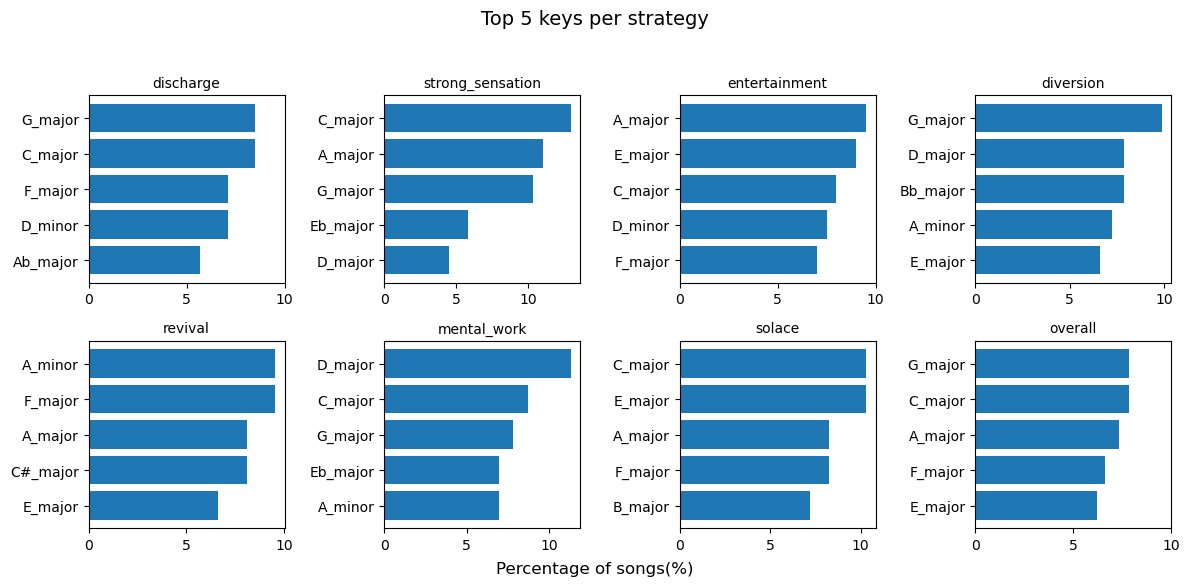

In [679]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

for i, (strategy, counts) in enumerate(strategy_key_counts.items()):
    axs[i].barh(counts.index, counts.values * 100)
    axs[i].set_title(strategy, fontsize=10)
    axs[i].invert_yaxis()
    axs[i].set_xticks([0, 5, 10])

fig.text(0.5, 0.04, "Percentage of songs(%)", ha='center', fontsize=12)

plt.suptitle("Top 5 keys per strategy", fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

In [811]:
top_keys

['G_major',
 'C_major',
 'A_major',
 'F_major',
 'E_major',
 'D_major',
 'C#_major',
 'Eb_major',
 'A_minor',
 'D_minor']

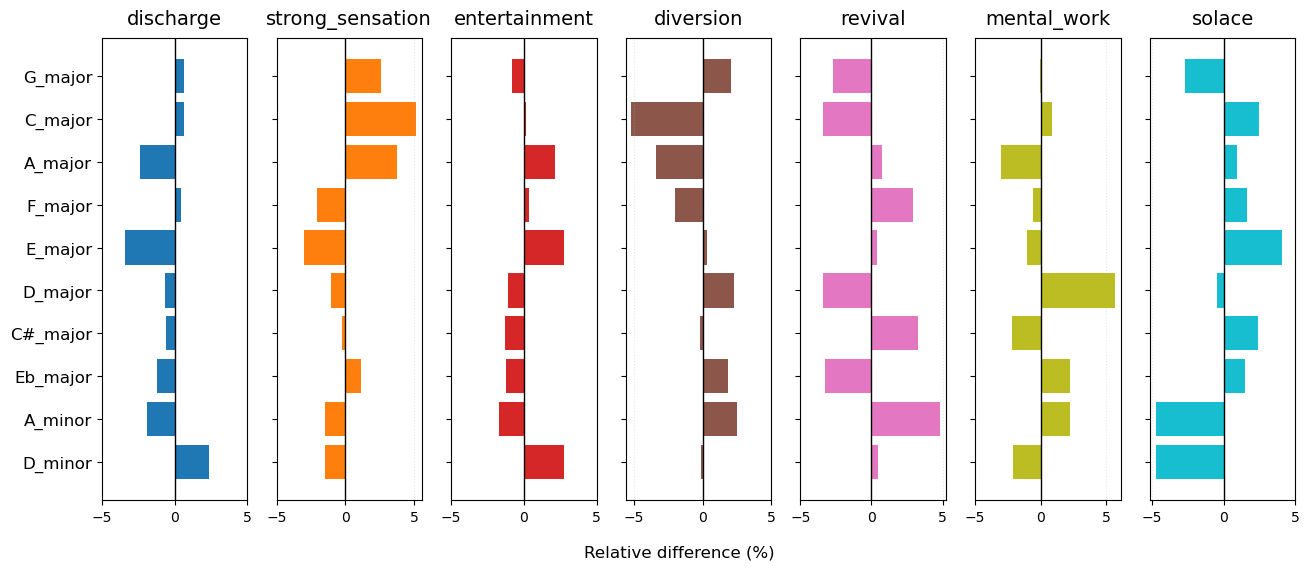

In [1007]:
overall = strategy_key_counts['overall']
top_keys = overall.nlargest(10).index.tolist()
top_keys = top_keys[::-1]
strategies = [s for s in strategy_key_counts.keys() if s != 'overall']

# make figure
n_strat = len(strategies)
fig, axes = plt.subplots(
    1, n_strat,
    figsize=(2.2 * n_strat, 6),
    sharey=True
)

colors = plt.cm.tab10(np.linspace(0, 1, n_strat))
y_pos = np.arange(len(top_keys))

for i, (strategy, ax) in enumerate(zip(strategies, axes)):
    counts = strategy_key_counts[strategy]
    
    # for each strategy, compute differences in key distributions from the average (proportion of the key in this strategy - proportion of keys overall)
    diffs = []
    for k in top_keys:
        p_strat = counts.get(k, 0) * 100
        p_overall = overall.get(k, 0) * 100
        diffs.append(p_strat - p_overall)
    diffs = np.array(diffs)

    ax.barh(y_pos, diffs, color=colors[i])
    ax.axvline(0, color='black', linewidth=1)

    ax.set_title(strategy, fontsize=14, pad=10)

    ax.set_xticks([-5, 0, 5])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=18)

    ax.grid(axis='x', linestyle=':', alpha=0.3)

    ax.set_yticks(y_pos)
    ax.set_yticklabels(top_keys, fontsize=12)

# fig.suptitle("Relative key frequency of 10 most frequent keys by strategy", y=0.98)
fig.supxlabel("Relative difference (%)")

plt.savefig("../outputs/figs/relative_key_frequency.jpeg")
# plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Comparing mode frequencies

In [682]:
df_keys['tonal.key_krumhansl.scale'].value_counts()

tonal.key_krumhansl.scale
major    662
minor    333
Name: count, dtype: int64

In [698]:
strategy_mode_counts={} 

for strategy in df_keys['strategy'].unique():
    df_st = df_keys[df_keys['strategy']==strategy]
    mode_counts = df_st['tonal.key_krumhansl.scale'].value_counts(normalize=True).head(5)
    strategy_mode_counts[strategy] = mode_counts

strategy_mode_counts['overall'] = df_keys['tonal.key_krumhansl.scale'].value_counts(normalize=True).head(5)

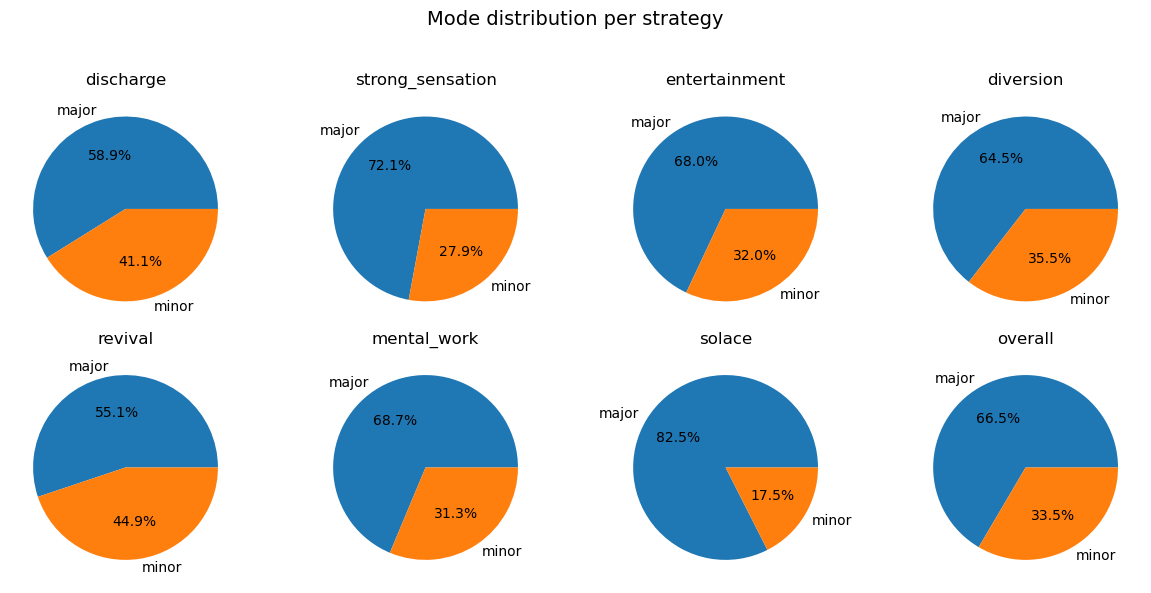

In [704]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()

for i, (strategy, counts) in enumerate(strategy_mode_counts.items()):
    labels = list(counts.keys())
    values = list(counts.values)
    axs[i].pie(values, labels=labels, autopct='%1.1f%%')
    axs[i].set_title(strategy, fontsize=12)


plt.suptitle("Mode distribution per strategy", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Comparing loudness features

<Axes: >

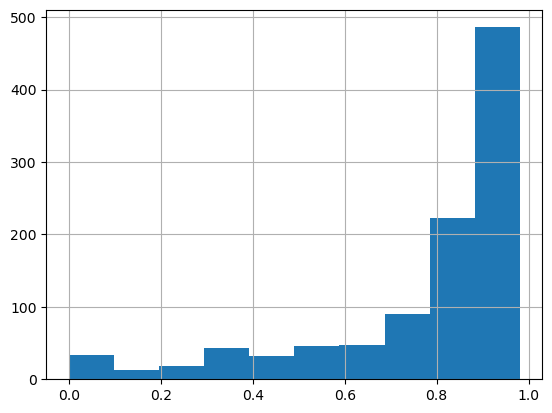

In [44]:
df_audio_features['lowlevel.average_loudness'].hist()

<Axes: >

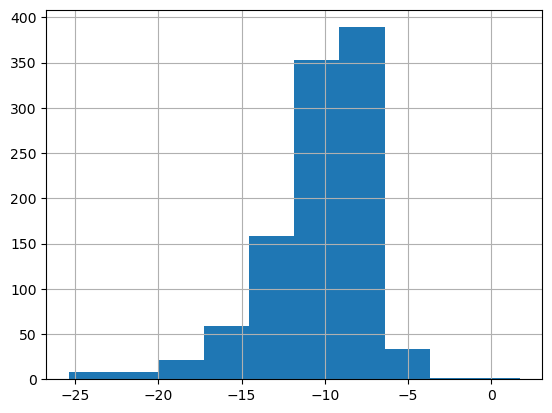

In [45]:
df_audio_features['lowlevel.loudness_ebu128.integrated'].hist()

### Ranges of numerical features

In [61]:
X_numerical = X.select_dtypes(include=['float64', 'int64'])
cm_numerical = X_numerical.corr()

ranges = pd.DataFrame({
    "min": X_numerical.min(),
    "max": X_numerical.max()
})

In [65]:
mask = (ranges["min"] >= -1) & (ranges["max"] <= 1)
print("Number of features between -1 and 1:", mask.sum())

Number of features between -1 and 1: 23


### Feature correlations

#### All numerical features

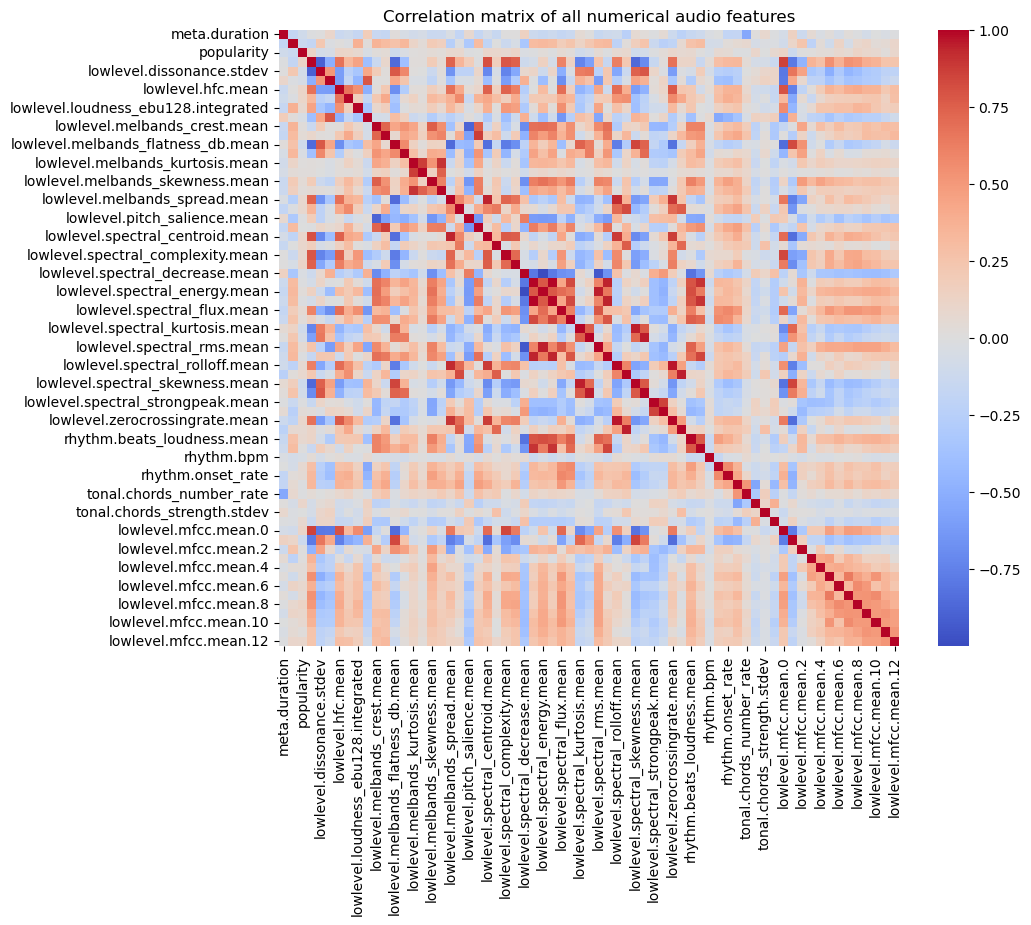

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_numerical, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix of all numerical audio features')
plt.show()

In [55]:
# print how many have correlation over +-0.5
upper_triangle = cm_numerical.where(np.triu(np.ones(cm_numerical.shape), k=1).astype(bool))
feature_correlations = upper_triangle.stack().sort_values(ascending=False)

print(f"=====Pairs of features with strong correlation (>0.8): {len(feature_correlations[abs(feature_correlations > 0.8)])}")
print(feature_correlations[abs(feature_correlations > 0.8)])

=====Pairs of features with strong correlation (>0.8): 31
lowlevel.spectral_decrease.stdev    lowlevel.spectral_energy.stdev        0.999689
lowlevel.spectral_rolloff.mean      lowlevel.zerocrossingrate.mean        0.965498
lowlevel.spectral_kurtosis.stdev    lowlevel.spectral_skewness.stdev      0.959039
lowlevel.spectral_kurtosis.mean     lowlevel.spectral_skewness.mean       0.951862
lowlevel.spectral_energy.mean       lowlevel.spectral_rms.mean            0.949403
lowlevel.spectral_rolloff.stdev     lowlevel.zerocrossingrate.stdev       0.946511
lowlevel.melbands_spread.mean       lowlevel.spectral_centroid.mean       0.941350
lowlevel.spectral_energy.stdev      lowlevel.spectral_rms.stdev           0.940690
lowlevel.spectral_decrease.stdev    lowlevel.spectral_rms.stdev           0.938544
lowlevel.melbands_spread.mean       lowlevel.spectral_rolloff.mean        0.927494
lowlevel.melbands_kurtosis.mean     lowlevel.melbands_skewness.stdev      0.903422
lowlevel.spectral_energy.stde

#### Spectral features

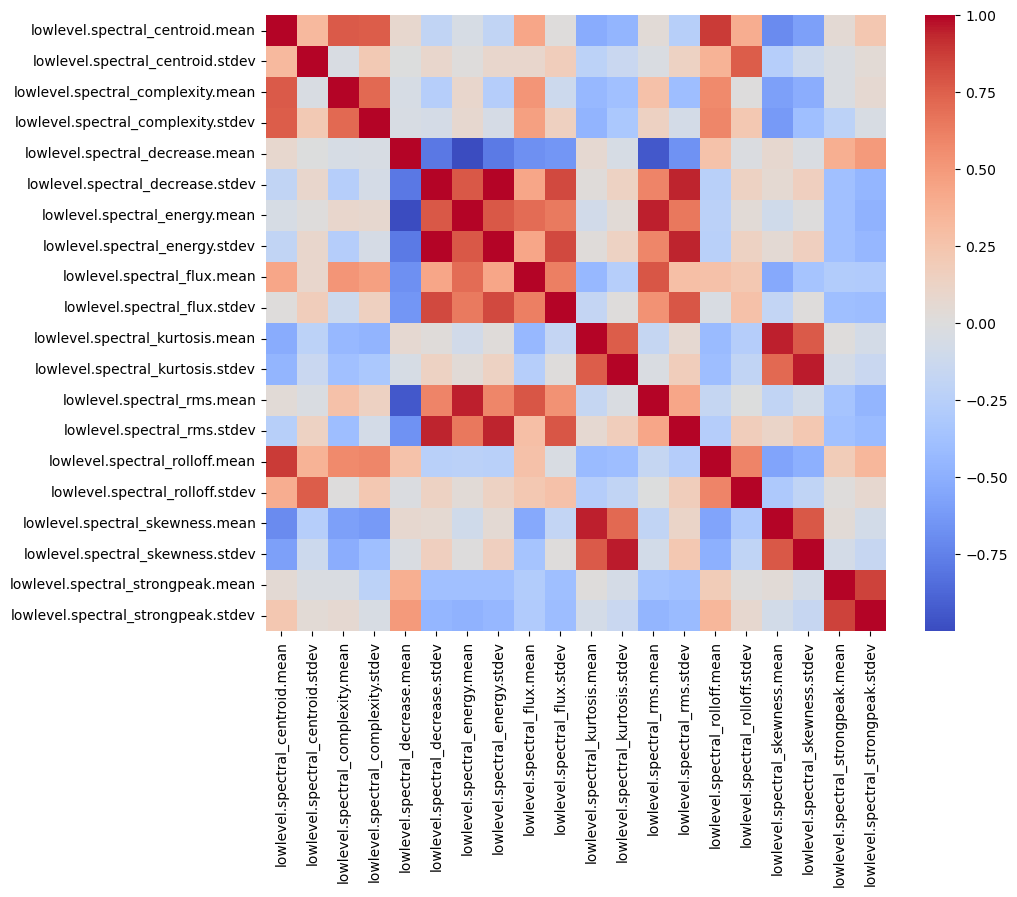

In [56]:
df_spectral = X_numerical.loc[:, X_numerical.columns.str.startswith('lowlevel.spectral_')]
cm_spectral = df_spectral.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_spectral, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

#### Melband features

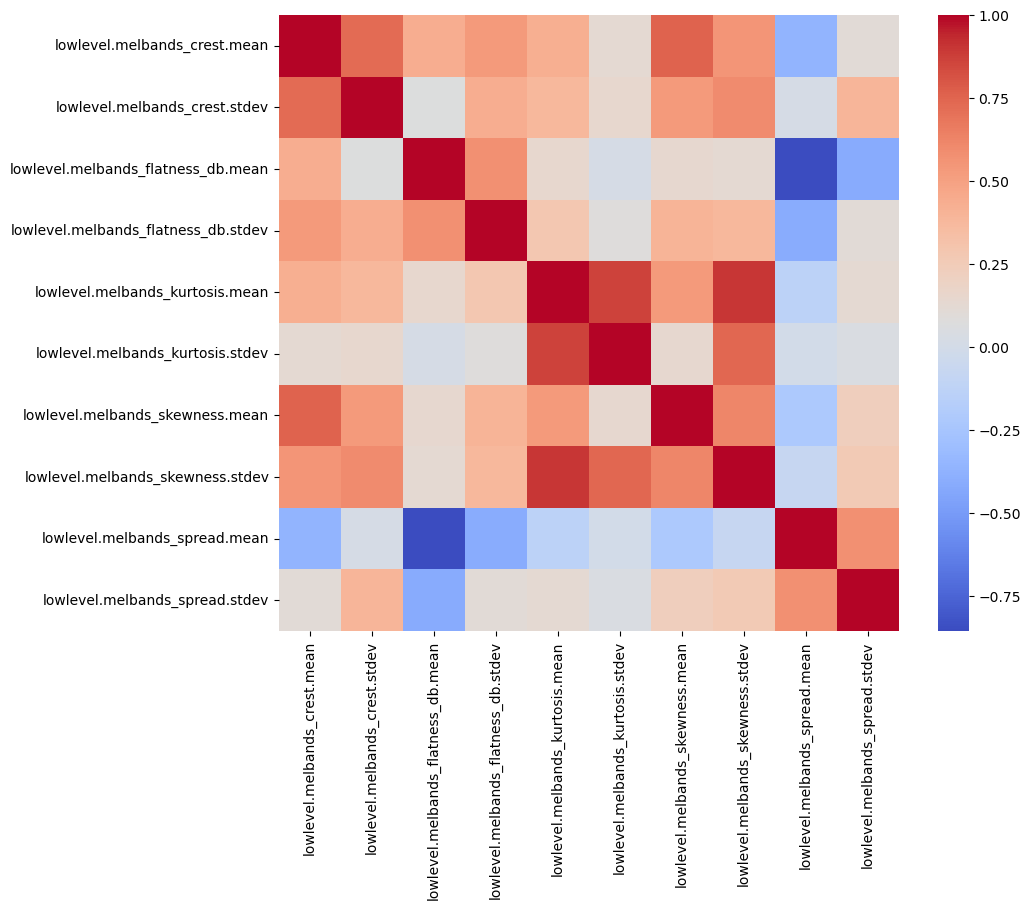

In [57]:
df_melbands = X_numerical.loc[:, X_numerical.columns.str.startswith('lowlevel.melbands_')]
cm_melbands = df_melbands.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_melbands, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

#### Rhythmic features

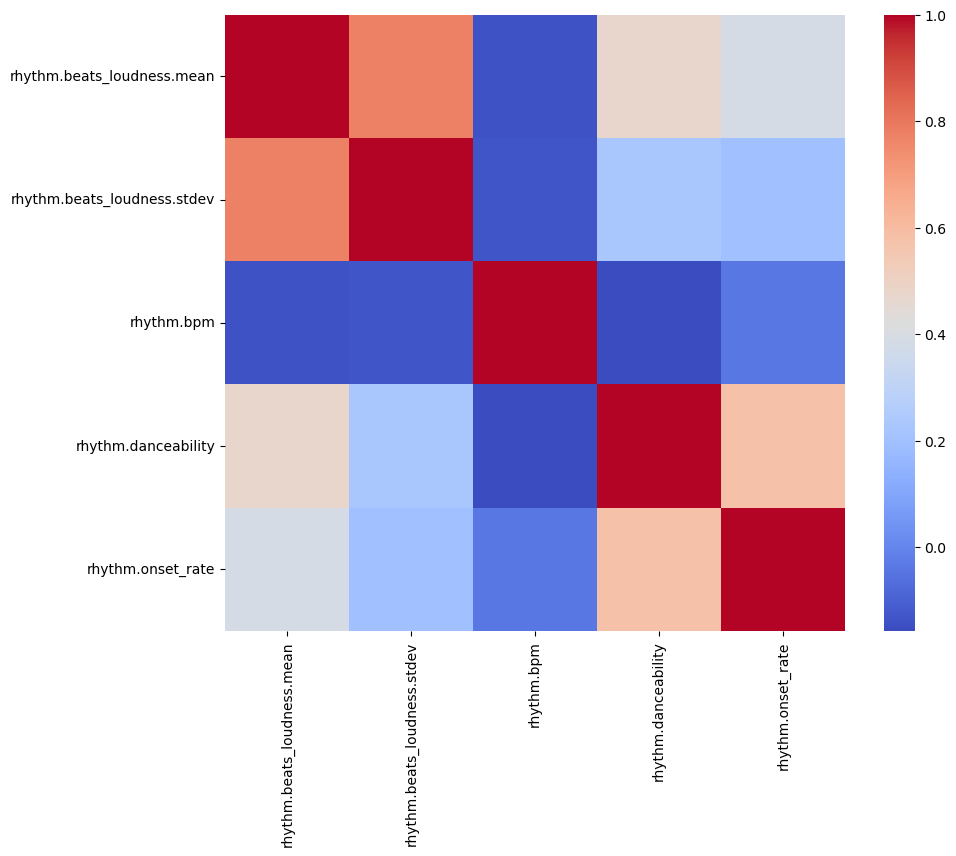

In [58]:
df_rhythm = X_numerical.loc[:, X_numerical.columns.str.startswith('rhythm')]
cm_rhythm = df_rhythm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rhythm, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

#### Tonal Features

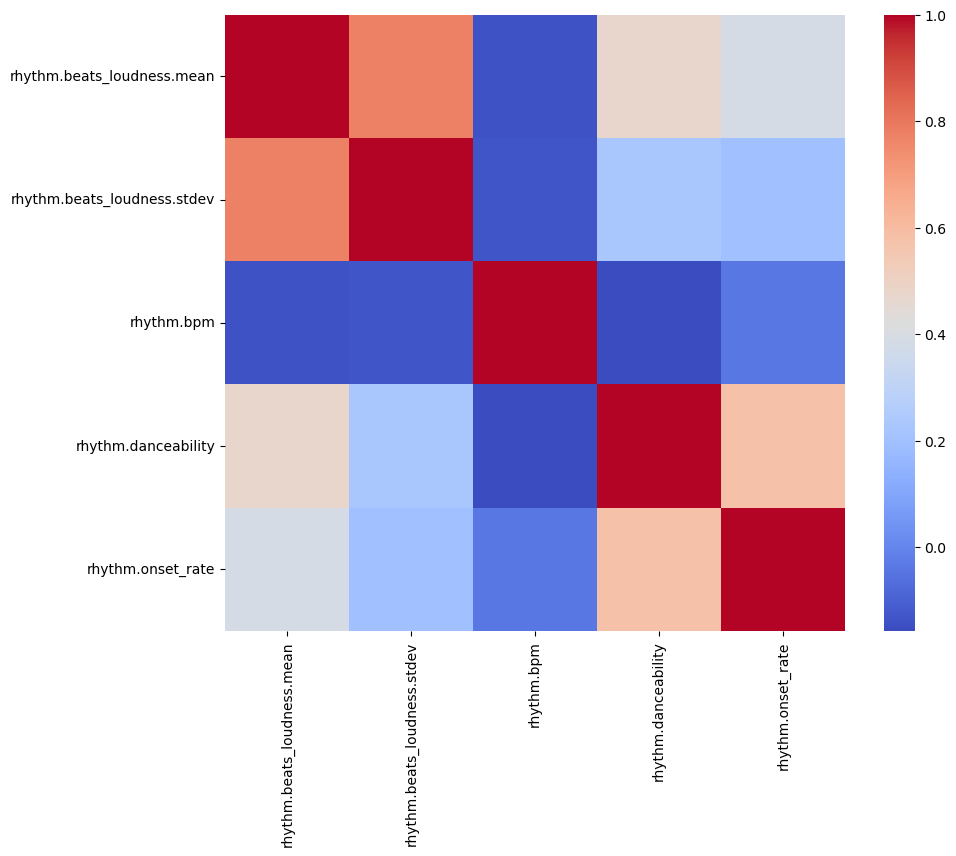

In [59]:
df_rhythm = X_numerical.loc[:, X_numerical.columns.str.startswith('rhythm')]
cm_rhythm = df_rhythm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cm_rhythm, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

### Compute mutual information

In [722]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder

# Remove multi-strategy instances from the data frst 
def process_multi_strategies(x):
    """
    If songs occur more than once, but for the same strategy (e.g. [('solace', 2)]) keep the strategy
    """
    if isinstance(x,str):
        # keep current x
        return x
    elif isinstance(x,list) and len(x) == 1:
        new_x = x[0][0]
        return new_x
    elif isinstance(x,list) and len(x) > 1:
        return np.nan
    
data['strategy'] = data['strategy'].apply(process_multi_strategies)
data = data.dropna(subset="strategy")

X = data.select_dtypes(include=["number"]).copy()          
X = X.fillna(X.median(numeric_only=True))            

le = LabelEncoder()
y = le.fit_transform(data["strategy"])

mi = mutual_info_classif(
    X, y,
    n_neighbors=3,
    random_state=0
)

mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

print("Top 10 features by mutual information with 'strategy':")
print(mi_series.head(5))

Top 10 features by mutual information with 'strategy':
rhythm.onset_rate                     0.116386
rhythm.danceability                   0.109639
lowlevel.zerocrossingrate.mean        0.101983
lowlevel.spectral_complexity.stdev    0.099058
lowlevel.spectral_flux.mean           0.098720
dtype: float64


### Violin plot of audio features

In [1010]:
cols = ['lowlevel.loudness_ebu128.integrated','rhythm.danceability','rhythm.bpm','strategy']
subset = data[cols]

feature_cols = [c for c in subset.columns if c != "strategy"]
strategies = list(np.unique(subset["strategy"]))

cmap = plt.cm.get_cmap("tab10", len(strategies))
strategy_to_color = {s: cmap(i) for i, s in enumerate(strategies)}

fig, axes = plt.subplots(
    nrows=1, ncols=3,
    figsize=(20, 7),
    sharex=True,
    sharey=False
)

axes = np.atleast_1d(axes).ravel()

for ax, feat in zip(axes, feature_cols):
    dists = [subset.loc[subset["strategy"] == s, feat].dropna().values for s in strategies]

    parts = ax.violinplot(dists, showmeans=False, showmedians=True, showextrema=True)

    # color each violin by strategy
    for i, body in enumerate(parts['bodies']):
        body.set_facecolor(strategy_to_color[strategies[i]])
        body.set_edgecolor("black")
        body.set_alpha(0.85)

    ax.set_title(feat, fontsize=15, pad=8)
    ax.set_xticks(range(1, len(strategies) + 1))
    ax.set_xticklabels(strategies, rotation=45, ha="right", fontsize=11)
    ax.grid(True, axis="y", linewidth=0.5, alpha=0.4)

# shared labels
fig.supxlabel("Strategy", fontsize=18, y=0.05)
fig.supylabel("Measure", fontsize=18, x=0.03)

# hide any unused axes (not needed here, but safe)
for ax in axes[len(feature_cols):]:
    ax.set_visible(False)

# ensure bottom labels show on the last (rightmost) subplot if Matplotlib prunes them
axes[-1].tick_params(labelbottom=True)

# spacing
fig.tight_layout(rect=(0.05, 0.07, 1, 0.98))
plt.show()


TypeError: '<' not supported between instances of 'list' and 'str'